# Lending Club Analysis

In [1]:
# Requirements: pandas, numpy, scikit-learn, xgboost (optional), shap (optional), python-pptx (optional)
# !pip install pandas numpy scikit-learn xgboost shap python-pptx joblib seaborn

## Import Libraries

In [2]:
import os
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({"figure.figsize": (8,5), "font.size": 11})
sns.set_style("whitegrid")

# Output folder
OUT = Path.cwd() / "lc_outputs"
OUT.mkdir(parents=True, exist_ok=True)

# CSV path
CSV_PATH = Path.cwd() / "Lending Club Data - DR_Demo_Lending_Club.csv"


## Load Dataset

In [3]:
# ==========
# Load data
# ==========
print("Loading:", CSV_PATH)
df = pd.read_csv(CSV_PATH)
print("Rows:", df.shape[0])
print("Columns:", len(df.columns))

# quick peek
display(df.head())


Loading: /Users/sm549c/Downloads/Lending Club Data - DR_Demo_Lending_Club.csv
Rows: 10000
Columns: 28


,Id,is_bad,emp_title,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,Notes,purpose_cat,...,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code
0,1,0,Time Warner Cable,10,MORTGAGE,50000.0,not verified,n,NaN,medical,...,NaN,15.0,0.0,12087,12.1,44.0,f,0.0,1,PC4
1,2,0,Ottawa University,1,RENT,39216.0,not verified,n,Borrower added on 04/14/11 > I will be using...,debt consolidation,...,NaN,4.0,0.0,10114,64.0,5.0,f,0.0,2,PC1
2,3,0,Kennedy Wilson,4,RENT,65000.0,not verified,n,NaN,credit card,...,NaN,4.0,0.0,81,0.6,8.0,f,0.0,3,PC4
3,4,0,TOWN OF PLATTEKILL,10,MORTGAGE,57500.0,not verified,n,NaN,debt consolidation,...,NaN,6.0,0.0,10030,37.1,23.0,f,0.0,2,PC2
4,5,0,Belmont Correctional,10,MORTGAGE,50004.0,VERIFIED - income,n,"I want to consolidate my debt, pay for a vacat...",debt consolidation,...,NaN,8.0,0.0,10740,40.4,21.0,f,0.0,3,PC3


## Descriptive Statistics

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 28 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Id                           10000 non-null  int64  
 1   is_bad                       10000 non-null  int64  
 2   emp_title                    9408 non-null   object 
 3   emp_length                   10000 non-null  object 
 4   home_ownership               10000 non-null  object 
 5   annual_inc                   9999 non-null   float64
 6   verification_status          10000 non-null  object 
 7   pymnt_plan                   10000 non-null  object 
 8   Notes                        6769 non-null   object 
 9   purpose_cat                  10000 non-null  object 
 10  purpose                      9996 non-null   object 
 11  zip_code                     10000 non-null  object 
 12  addr_state                   10000 non-null  object 
 13  debt_to_income   

In [5]:
df['emp_length'].value_counts()

emp_length
10    2160
1     2083
2     1183
3     1010
4      889
5      779
6      535
7      421
8      351
9      331
na     250
22       5
11       2
33       1
Name: count, dtype: int64

In [6]:
df.describe()

,Id,is_bad,annual_inc,debt_to_income,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,mths_since_last_major_derog
count,10000.00000,10000.000000,9999.000000,10000.000000,9995.000000,9995.000000,3684.000000,840.000000,9995.000000,9995.000000,1.000000e+04,9974.000000,9995.000000,9968.0,10000.000000
mean,5000.50000,0.129500,68203.011539,13.338704,0.148174,1.066933,35.890337,61.652381,9.334567,0.060130,1.427101e+04,48.450771,22.011306,0.0,2.002200
std,2886.89568,0.335769,48590.252757,6.754212,0.506270,1.476052,22.361443,46.189619,4.526590,0.251245,2.543791e+04,28.220557,11.709400,0.0,0.810963
min,1.00000,0.000000,2000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000e+00,0.000000,1.000000,0.0,1.000000
25%,2500.75000,0.000000,40000.000000,8.160000,0.000000,0.000000,18.000000,0.000000,6.000000,0.000000,3.524500e+03,25.000000,13.000000,0.0,1.000000
50%,5000.50000,0.000000,58000.000000,13.410000,0.000000,1.000000,34.000000,86.000000,9.000000,0.000000,8.645500e+03,48.700000,20.000000,0.0,2.000000
75%,7500.25000,0.000000,82000.000000,18.692500,0.000000,2.000000,53.000000,101.000000,12.000000,0.000000,1.695225e+04,71.800000,29.000000,0.0,3.000000
max,10000.00000,1.000000,900000.000000,29.990000,11.000000,25.000000,120.000000,119.000000,39.000000,3.000000,1.207359e+06,100.600000,90.000000,0.0,3.000000


## Target Analysis

In [7]:
target_col = "is_bad"

print("Using target:", target_col)
print("Target distribution:")
print(df[target_col].value_counts(dropna=False, normalize=True))


Using target: is_bad
Target distribution:
is_bad
0    0.8705
1    0.1295
Name: proportion, dtype: float64


## Feature Engineering

In [8]:
# ======================================
# Basic cleaning & drop columns
# ======================================
# Drop obvious ID/text columns not useful for modeling
drop_candidates = ["Id","emp_title","Notes","purpose","zip_code","addr_state","mths_since_last_record",
                   "initial_list_status","collections_12_mths_ex_med","policy_code"]

print("Dropping:", drop_candidates)
df = df.drop(columns=drop_candidates)


Dropping: ['Id', 'emp_title', 'Notes', 'purpose', 'zip_code', 'addr_state', 'mths_since_last_record', 'initial_list_status', 'collections_12_mths_ex_med', 'policy_code']


In [9]:
# ======================
# Convert date into age
# ======================
# Ensure column is in datetime format
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format='%m/%d/%y')

# Calculate age in years
df['credit_age_years'] = (datetime.now() - df['earliest_cr_line']).dt.days / 365.25

# Handle invalid or missing dates
df['credit_age_years'] = df['credit_age_years'].fillna(df['credit_age_years'].median())

# Check results
print(df[['earliest_cr_line', 'credit_age_years']].head())

# Convert the emp_length to numeric
df['emp_length'] = pd.to_numeric(df['emp_length'], errors='coerce')
print(df['emp_length'].value_counts())

  earliest_cr_line  credit_age_years
0       1992-12-01         32.906229
1       2005-11-01         19.989049
2       1970-06-01         55.408624
3       1982-09-01         43.156742
4       1999-10-01         26.075291
emp_length
10.0    2160
1.0     2083
2.0     1183
3.0     1010
4.0      889
5.0      779
6.0      535
7.0      421
8.0      351
9.0      331
22.0       5
11.0       2
33.0       1
Name: count, dtype: int64


## Feature Selection

In [10]:
# ==================
# Feature selection  
# ==================

# Choose numeric and categorical features for modeling,
NUMERIC = df.select_dtypes(include=["int64","float64"]).columns.tolist()
NUMERIC = [c for c in NUMERIC if c != target_col]  # exclude target

CATEGORICAL = df.select_dtypes(include=["object","category","bool"]).columns.tolist()
# limit categorical to those with <= 50 unique values (adjustable)
CATEGORICAL = [c for c in CATEGORICAL if df[c].nunique() <= 50]

# Remove any columns with > 95% missing
cols_to_drop = [c for c in df.columns if df[c].isna().mean() > 0.95]
print("Drop columns with most missing values:", cols_to_drop)
if cols_to_drop:
    print("Dropping >95% missing:", cols_to_drop)
    df = df.drop(columns=cols_to_drop)
    NUMERIC = [c for c in NUMERIC if c not in cols_to_drop]
    CATEGORICAL = [c for c in CATEGORICAL if c not in cols_to_drop]

print("Numeric features chosen:", len(NUMERIC))
print("Categorical features chosen:", len(CATEGORICAL))

# keep final feature lists (you can customize manually)
FEATURES = NUMERIC + CATEGORICAL
print("Total features to use:", len(FEATURES))

Drop columns with most missing values: []
Numeric features chosen: 13
Categorical features chosen: 4
Total features to use: 17


## Exploratory Data Analysis

In [11]:
# ================================
# Exploratory Data Analysis (EDA) 
# ================================
# Basic distributions
print("\n--- EDA summary ---")
print("Default rate:", df[target_col].mean())

# Missingness overview (top 15)
missing = df[FEATURES + [target_col]].isna().sum().sort_values(ascending=False)
print("Top missing counts:\n", missing.head(15))



--- EDA summary ---
Default rate: 0.1295
Top missing counts:
 mths_since_last_delinq         6316
emp_length                      250
revol_util                       26
delinq_2yrs                       5
inq_last_6mths                    5
open_acc                          5
pub_rec                           5
total_acc                         5
annual_inc                        1
debt_to_income                    0
revol_bal                         0
mths_since_last_major_derog       0
credit_age_years                  0
home_ownership                    0
verification_status               0
dtype: int64


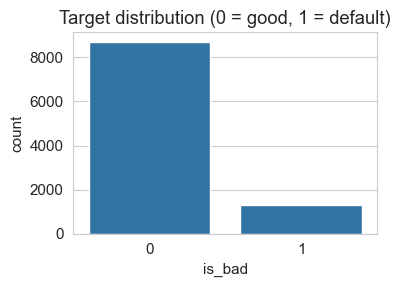

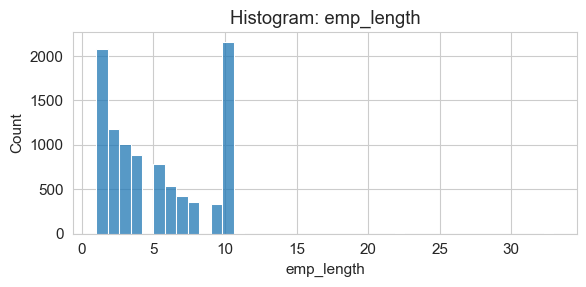

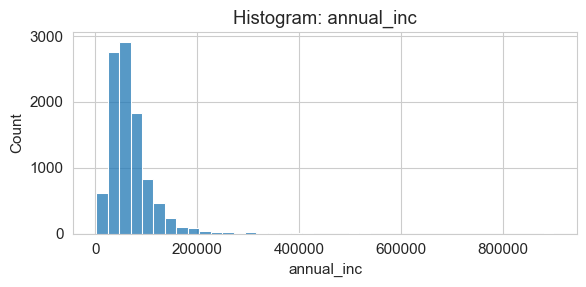

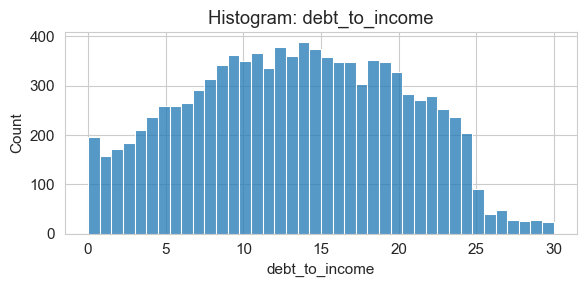

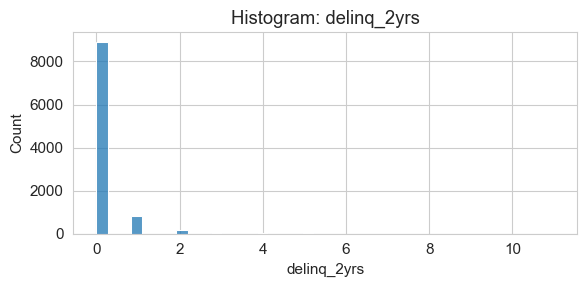

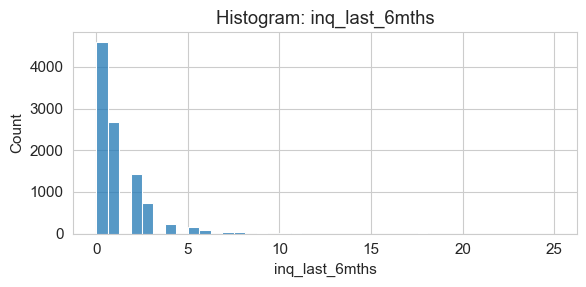

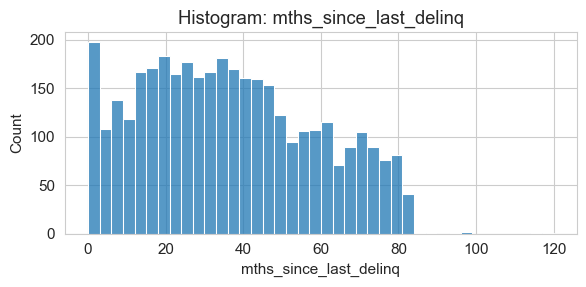

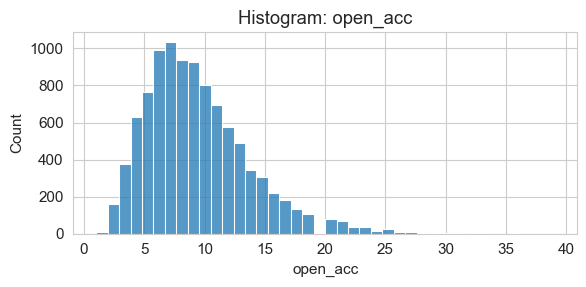

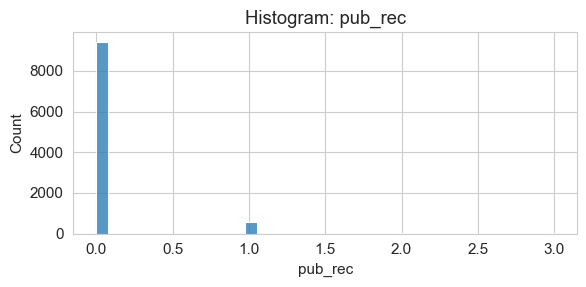

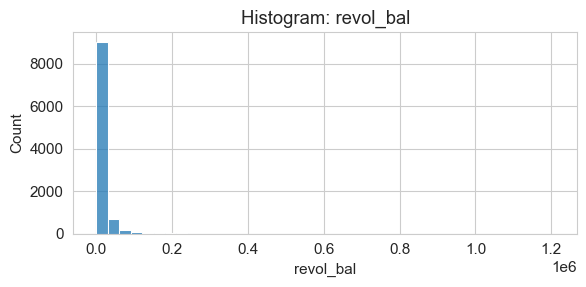

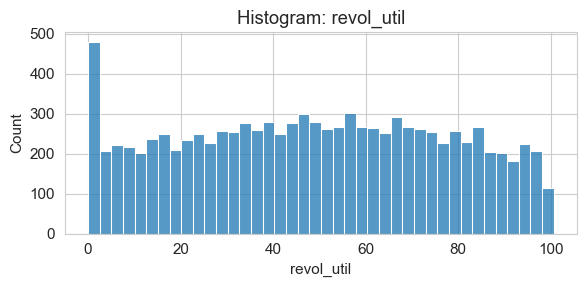

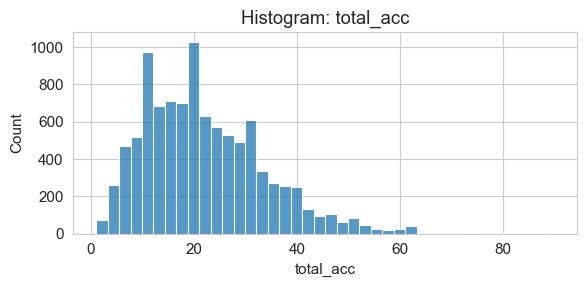

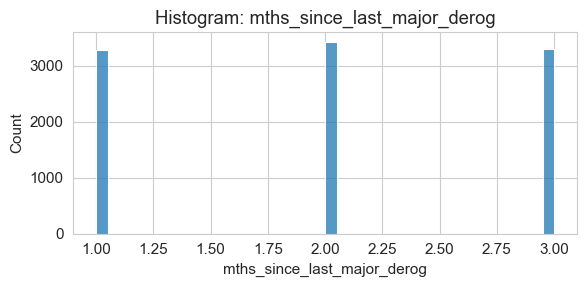

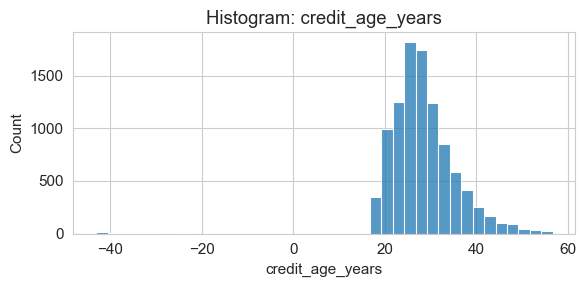

In [12]:
# Target distribution
plt.figure(figsize=(4,3))
sns.countplot(x=target_col, data=df)
plt.title("Target distribution (0 = good, 1 = default)")
plt.tight_layout()
plt.show()

# Numeric histograms
for col in NUMERIC:
    plt.figure(figsize=(6,3))
    sns.histplot(df[col].dropna(), bins=40, kde=False)
    plt.title(f"Histogram: {col}")
    plt.tight_layout()
    plt.show()


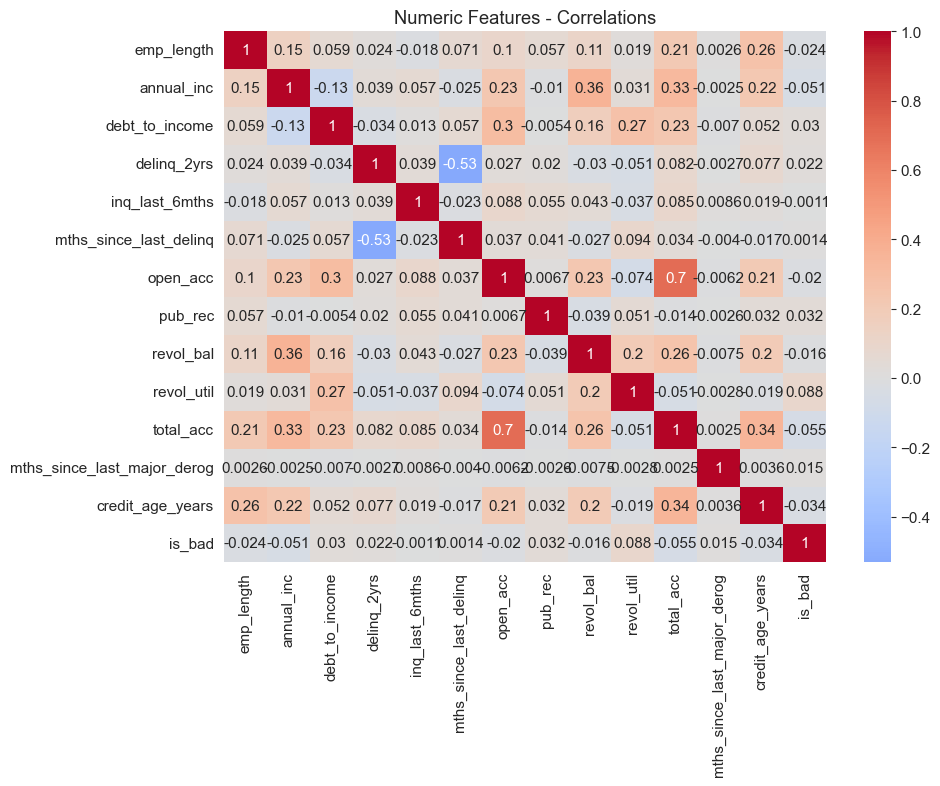

In [13]:
# Correlation heatmap of numeric features
if len(NUMERIC) >= 2:
    num_corr = df[NUMERIC].corr().abs()
    plt.figure(figsize=(10,8))
    sns.heatmap(df[NUMERIC + [target_col]].corr(), cmap="coolwarm", center=0, annot=True)
    plt.title("Numeric Features - Correlations")
    plt.tight_layout()
    plt.show()


In [14]:
if NUMERIC:
    corr_with_target = df[NUMERIC].corrwith(df[target_col]).sort_values(ascending=False)

corr_with_target

revol_util                     0.087876
pub_rec                        0.032174
debt_to_income                 0.029873
delinq_2yrs                    0.021842
mths_since_last_major_derog    0.015481
mths_since_last_delinq         0.001358
inq_last_6mths                -0.001146
revol_bal                     -0.016202
open_acc                      -0.020356
emp_length                    -0.023712
credit_age_years              -0.033804
annual_inc                    -0.050975
total_acc                     -0.055307
dtype: float64

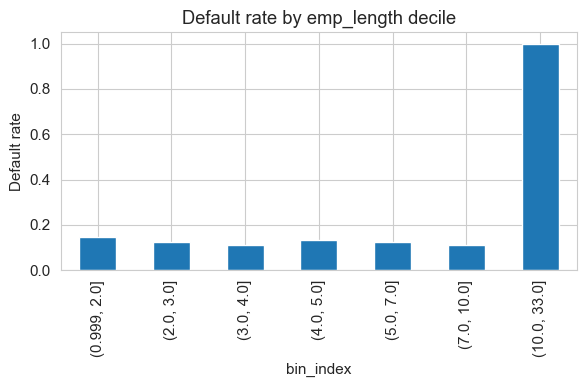

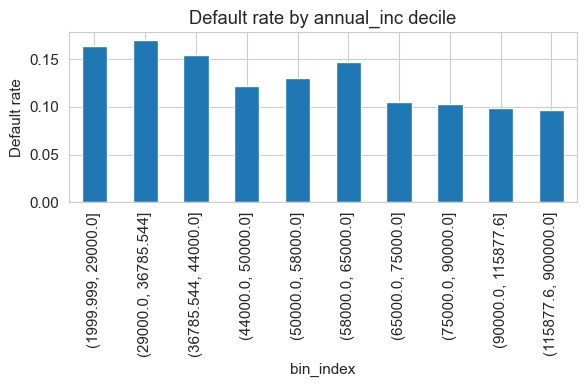

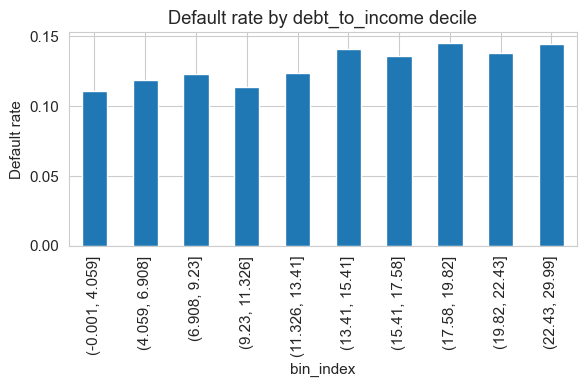

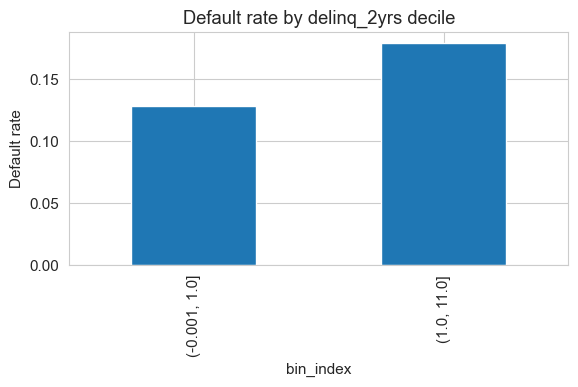

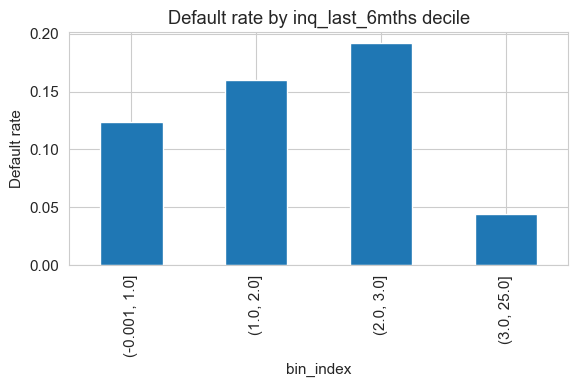

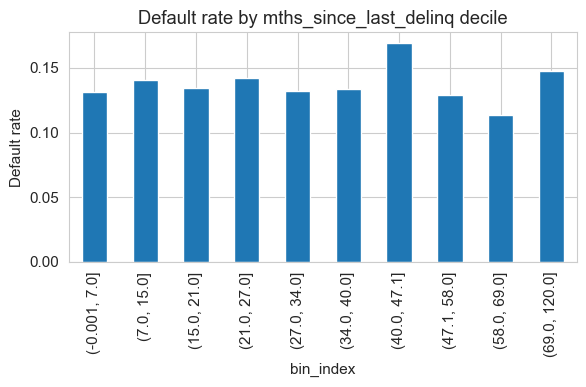

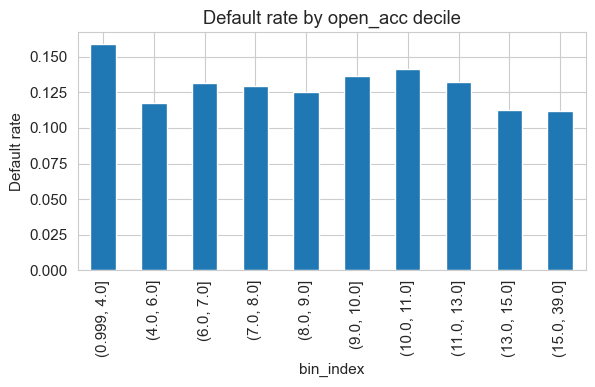

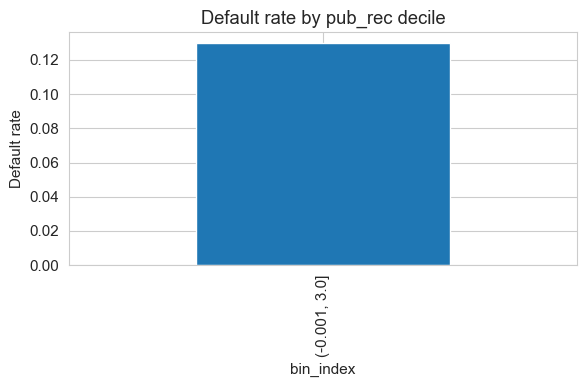

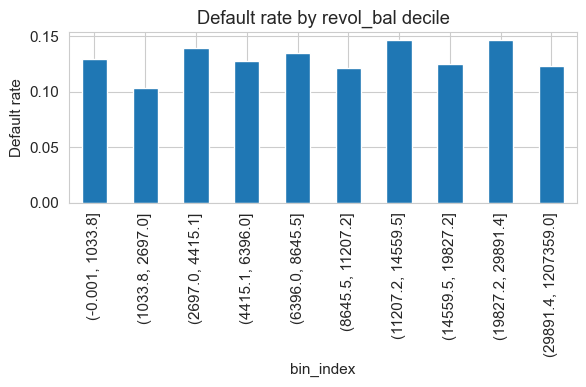

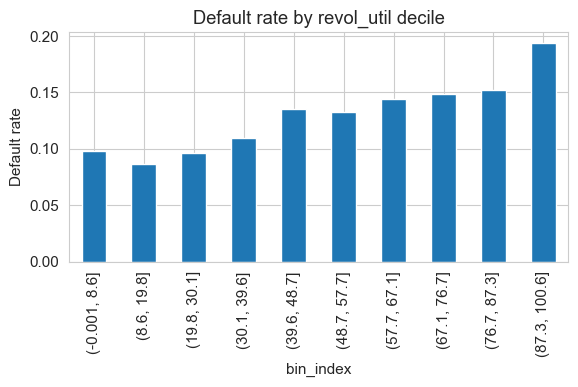

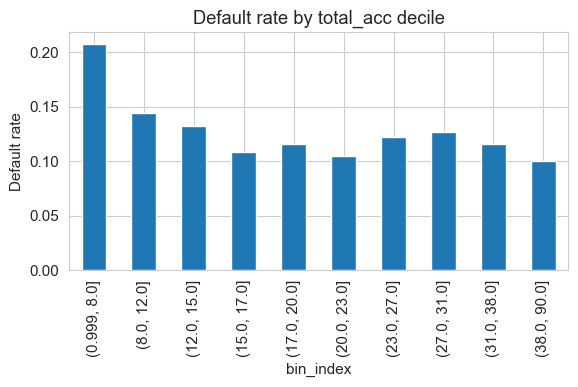

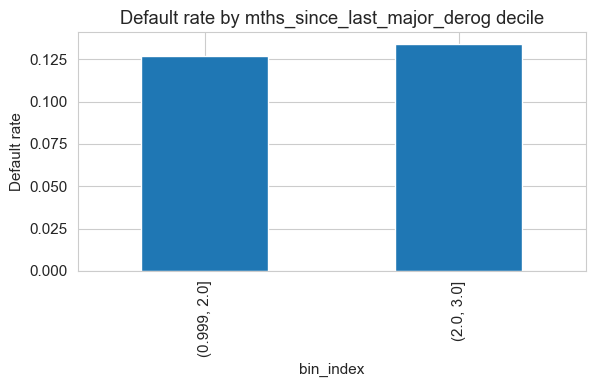

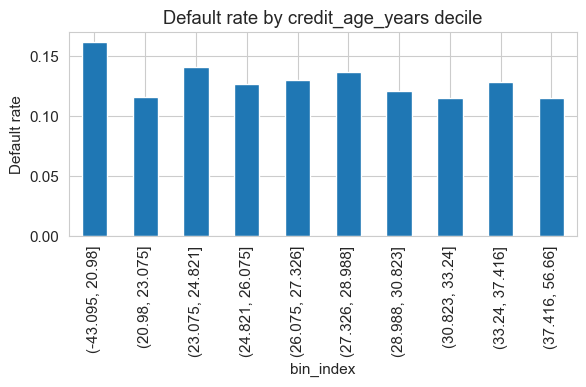

In [15]:
# Numeric feature vs target: binned default rate
for col in NUMERIC:
    tmp = df[[col, target_col]].dropna()
    tmp["bin_index"] = pd.qcut(tmp[col], q=10, duplicates="drop")
    br = tmp.groupby("bin_index")[target_col].mean()
    plt.figure(figsize=(6,4))
    br.plot(kind="bar")
    plt.title(f"Default rate by {col} decile")
    plt.ylabel("Default rate")
    plt.tight_layout()
    plt.show()


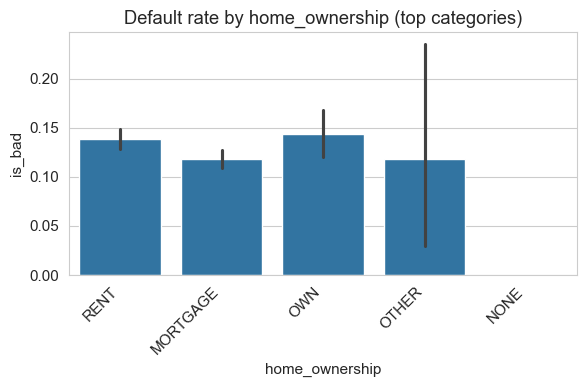

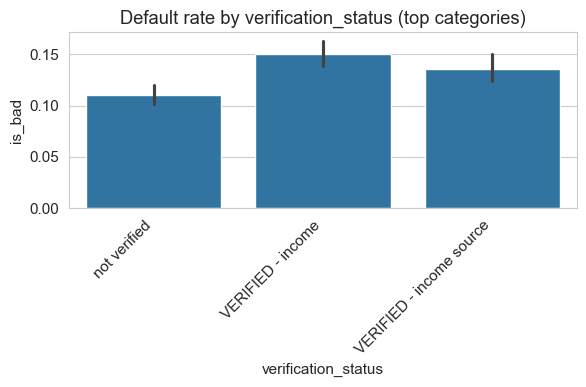

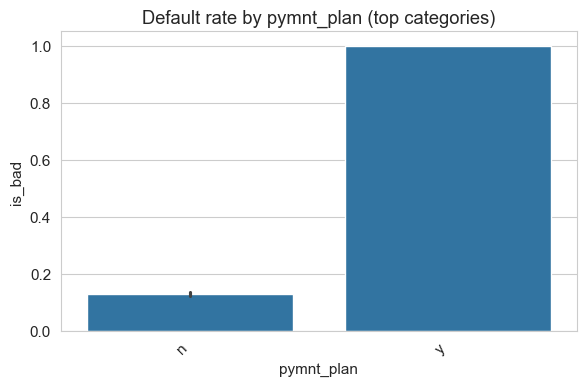

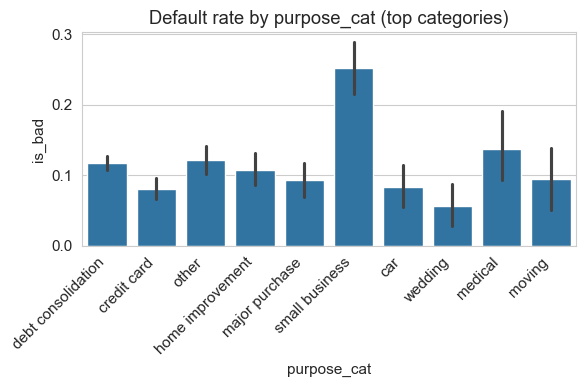

In [16]:
# Categorical vs target (top categories)
for col in CATEGORICAL:
    plt.figure(figsize=(6,4))
    order = df[col].value_counts(ascending=False).index[:10]
    sns.barplot(x=col, y=target_col, data=df, order=order)
    plt.xticks(rotation=45, ha="right")
    plt.title(f"Default rate by {col} (top categories)")
    plt.tight_layout()
    plt.show()


## Preprocessing Pipeline

In [17]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# numeric pipeline
num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# categorical pipeline
cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="MISSING")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", dtype=np.float32))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, NUMERIC),
        ("cat", cat_transformer, CATEGORICAL),
    ],
    remainder="drop", verbose_feature_names_out=False
)

# Fit-transform once to get output feature dimension
X = df[FEATURES].copy()
y = df[target_col].astype(int)

preprocessor.fit(X)
print("Preprocessor fitted.")


Preprocessor fitted.


## Split the dataset for Training

In [18]:
# ===========================================
# Preprocessing pipelines & train/test split
# ===========================================
from sklearn.model_selection import train_test_split

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
print("Train / Test:", X_train.shape, X_test.shape)


Train / Test: (7000, 17) (3000, 17)


## Model Training

In [19]:
# ======================================================================
# Model training (Logistic Regression, RandomForest, XGBoost/GradBoost)
# ======================================================================
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

models = {}

# Logistic Regression (balanced)
pipe_lr = Pipeline([
    ("preproc", preprocessor),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", solver="saga"))
])
pipe_lr.fit(X_train, y_train)
models["LogisticRegression"] = pipe_lr
print("Trained LogisticRegression")

# Random Forest
pipe_rf = Pipeline([
    ("preproc", preprocessor),
    ("clf", RandomForestClassifier(n_estimators=1000, random_state=42, class_weight="balanced", n_jobs=-10))
])
pipe_rf.fit(X_train, y_train)
models["RandomForest"] = pipe_rf
print("Trained RandomForest")

# XGBoost
from xgboost import XGBClassifier
pipe_xgb = Pipeline([
    ("preproc", preprocessor),
    ("clf", XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42, n_estimators=1000, n_jobs=10))
])
pipe_xgb.fit(X_train, y_train)
models["XGBoost"] = pipe_xgb
print("Trained XGBoost")


Trained LogisticRegression
Trained RandomForest
Trained XGBoost


## Model Evaluation

Evaluating: LogisticRegression
Evaluating: RandomForest
Evaluating: XGBoost


,model,accuracy,precision,recall,f1,auc,confusion_matrix
0,LogisticRegression,0.697667,0.223642,0.541237,0.316503,0.689753,"[[1883, 729], [178, 210]]"
2,XGBoost,0.870000,0.492537,0.170103,0.252874,0.655500,"[[2544, 68], [322, 66]]"
1,RandomForest,0.881000,0.969697,0.082474,0.152019,0.690316,"[[2611, 1], [356, 32]]"


Saved model_comparison.csv


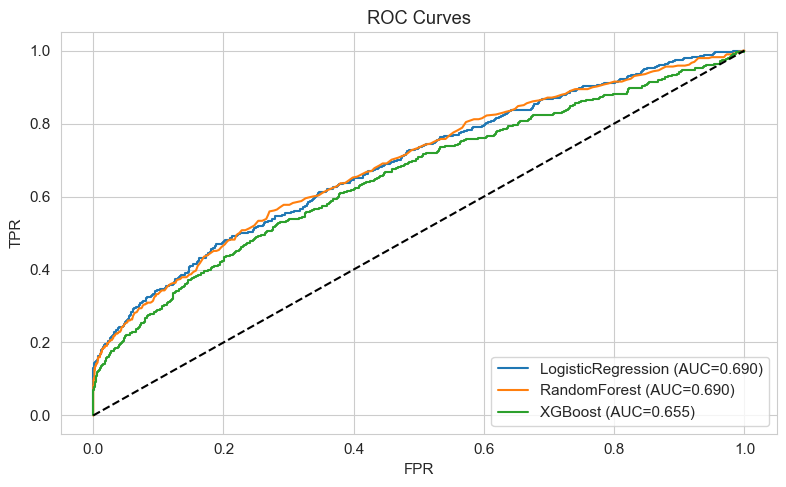

Saved AUC-ROC curve plot - roc_curves.png


In [20]:
# ==================================
# Evaluation helper & results table
# ==================================
def evaluate_model(pipe, X_test, y_test):
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, y_proba)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)
    return {"accuracy":acc, "precision":prec, "recall":rec, "f1":f1, "auc":auc, "confusion_matrix":cm.tolist(), "y_proba":y_proba, "y_pred":y_pred}

results_list = []
for name, pipe in models.items():
    print("Evaluating:", name)
    res = evaluate_model(pipe, X_test, y_test)
    res_row = {"model": name, "accuracy": res["accuracy"], "precision": res["precision"],
               "recall": res["recall"], "f1": res["f1"], "auc": res["auc"], "confusion_matrix": res["confusion_matrix"]}
    results_list.append(res_row)
    
results_df = pd.DataFrame(results_list).sort_values(by="f1", ascending=False)
display(results_df)
results_df.to_csv(OUT / "model_comparison.csv", index=False)
print("Saved model_comparison.csv")

# Plot ROC curves if probabilities available
from sklearn.metrics import roc_curve, auc
plt.figure()
for name, pipe in models.items():
    y_proba = pipe.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")

plt.plot([0,1],[0,1],"k--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(OUT / "roc_curves.png")
plt.show()
print("Saved AUC-ROC curve plot - roc_curves.png")

## Feature Importance

### Logistic Regression Feature Importance

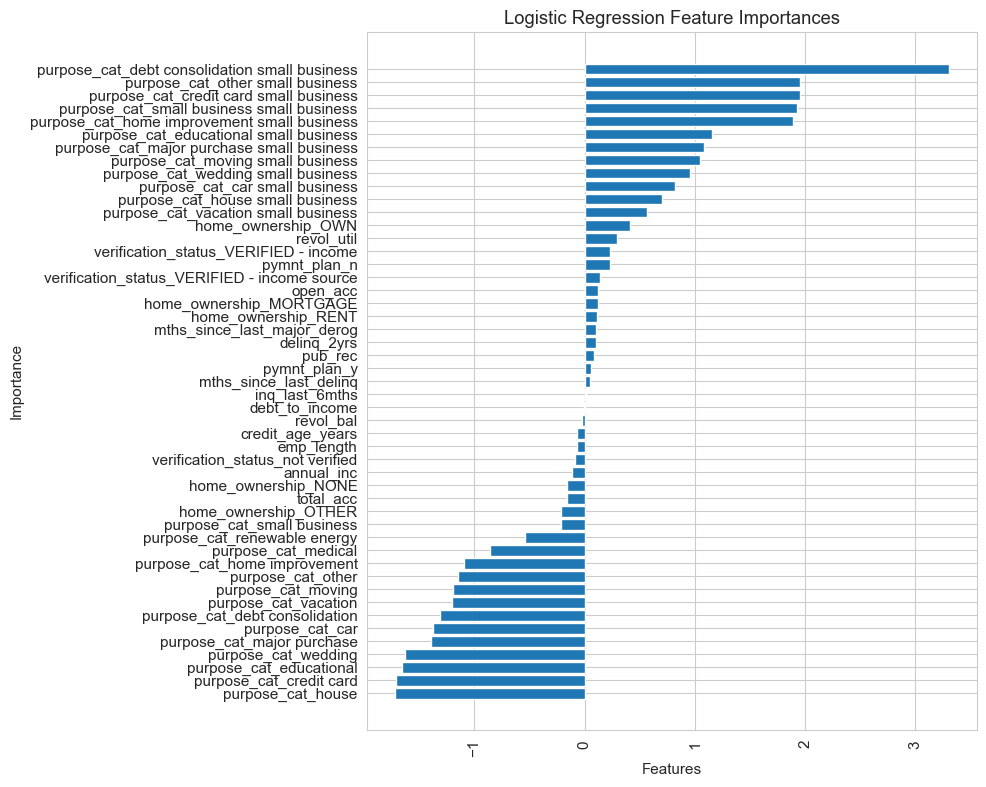

In [21]:
# get the classifier from the pipeline
lr_clf = models['LogisticRegression'].named_steps['clf']

# Get coefficients
feature_coefficients = lr_clf.coef_[0] 

# Get feature names
feature_names = models['LogisticRegression'][:-1].get_feature_names_out()

feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': feature_coefficients})
# feature_importance['Absolute_Coefficient'] = abs(feature_importance['Coefficient'])
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)

# Sort features by importance
sorted_idx = np.argsort(feature_coefficients)
sorted_importances = feature_coefficients[sorted_idx]
sorted_feature_names = [feature_names[i] for i in sorted_idx]

plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_importances)), sorted_importances, tick_label=sorted_feature_names)
plt.xticks(rotation=90)
plt.title("Logistic Regression Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

### RandomForest Feature Importance

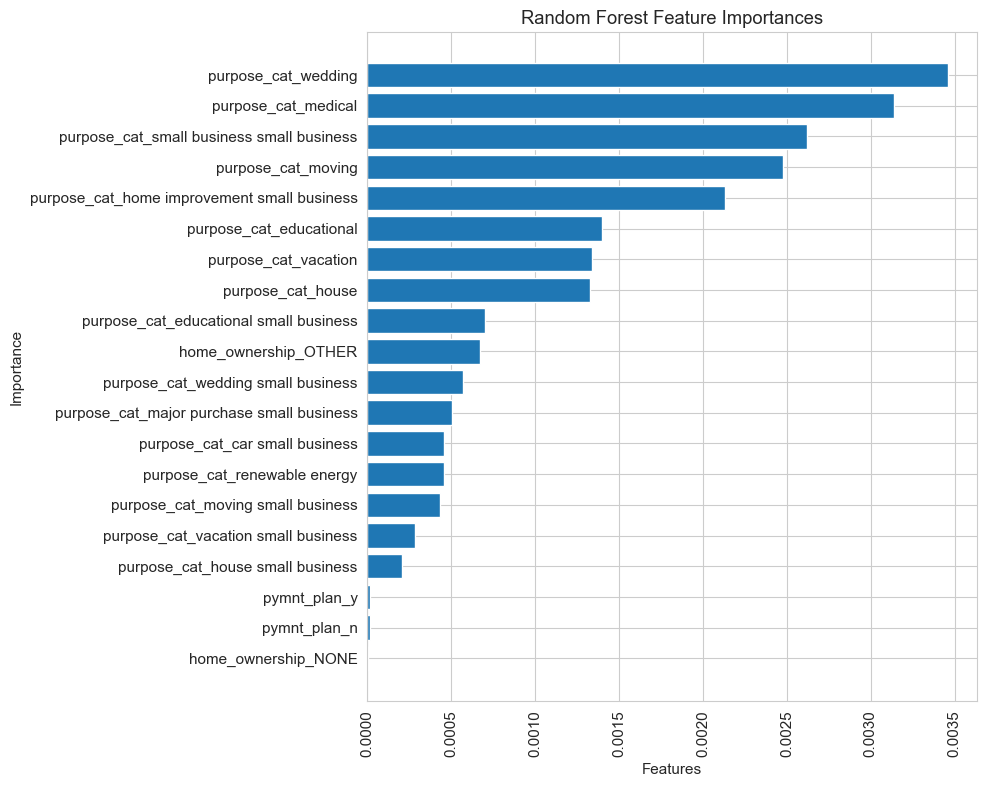

In [22]:
# get the classifier from the pipeline
rf_clf = models['RandomForest'].named_steps['clf']

# get feature importances
feature_importances = rf_clf.feature_importances_

# feature names
feature_names = models['RandomForest'][:-1].get_feature_names_out()

# Sort features by importance
sorted_idx = np.argsort(feature_importances)
sorted_importances = feature_importances[sorted_idx]
sorted_feature_names = [feature_names[i] for i in sorted_idx]

plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_importances[:20])), sorted_importances[:20], tick_label=sorted_feature_names[:20])
plt.xticks(rotation=90)
plt.title("Random Forest Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

### XGBoost Feature Importance

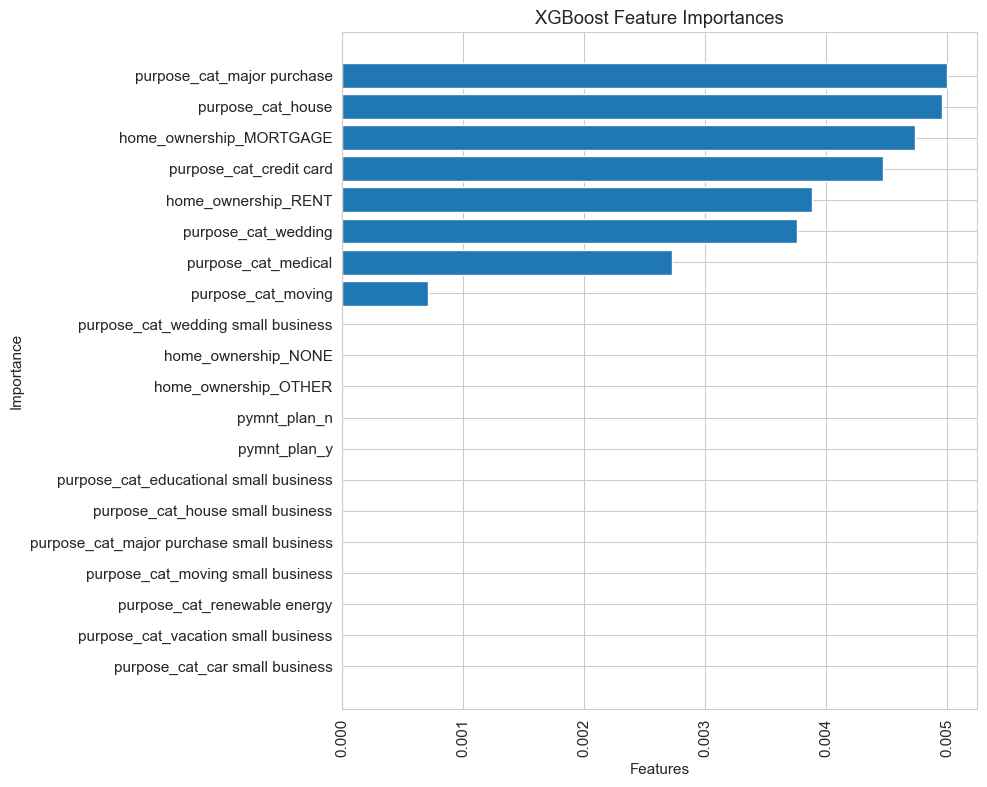

In [23]:
# get the classifier from the pipeline
xgb_clf = models['XGBoost'].named_steps['clf']

# get feature importances
feature_importances = xgb_clf.feature_importances_

# feature names
feature_names = models['XGBoost'][:-1].get_feature_names_out()

# Sort features by importance
sorted_idx = np.argsort(feature_importances)
sorted_importances = feature_importances[sorted_idx]
sorted_feature_names = [feature_names[i] for i in sorted_idx]

plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_importances[:20])), sorted_importances[:20], tick_label=sorted_feature_names[:20])
plt.xticks(rotation=90)
plt.title("XGBoost Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

## Model Interpretation using SHAP Analysis

### LinearRegression Model Interpretation

In [25]:
import shap
shap.initjs()

explainer = shap.Explainer(lr_clf)
shap_values = explainer.shap_values(X_test)

ModuleNotFoundError: No module named 'shap'

In [ ]:
shap.summary_plot(shap_values, X_test)

In [ ]:
shap.summary_plot(shap_values[0], X_test)

### RandomForest Model Interpretation

In [ ]:
explainer = shap.Explainer(rf_clf)
shap_values = explainer.shap_values(X_test)

In [ ]:
shap.summary_plot(shap_values, X_test)

In [ ]:
shap.summary_plot(shap_values[0], X_test)

### XGBoost Model Interpretation

In [ ]:
explainer = shap.Explainer(xgb_clf)
shap_values = explainer.shap_values(X_test)

In [ ]:
shap.summary_plot(shap_values, X_test)

In [ ]:
shap.summary_plot(shap_values[0], X_test)